Dataset loaded successfully:
   CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1     4.0         Mobile Phone         3              6.0   
1       50002      1     NaN                Phone         1              8.0   
2       50003      1     NaN                Phone         1             30.0   
3       50004      1     0.0                Phone         3             15.0   
4       50005      1     0.0                Phone         1             12.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0           Debit Card  Female             3.0                         3   
1                  UPI    Male             3.0                         4   
2           Debit Card    Male             2.0                         4   
3           Debit Card    Male             2.0                         4   
4                   CC    Male             NaN                         3   

     PreferedOrderCat  Satisfacti

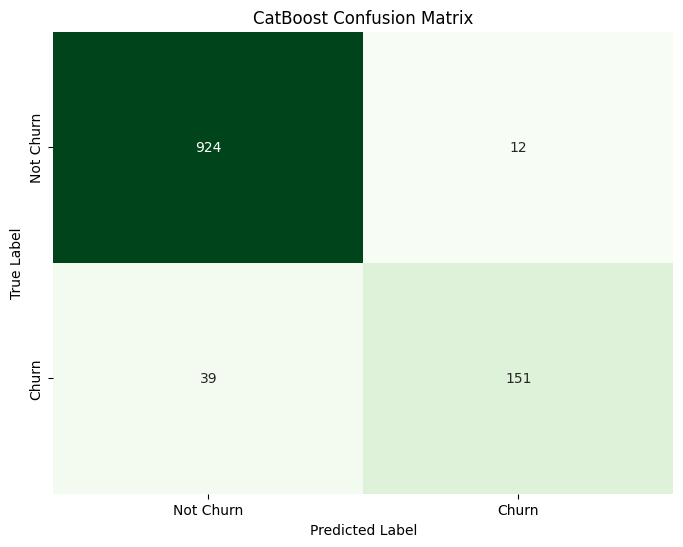


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       936
           1       0.93      0.79      0.86       190

    accuracy                           0.95      1126
   macro avg       0.94      0.89      0.91      1126
weighted avg       0.95      0.95      0.95      1126


CatBoost Feature Importances:
                        Feature  Importance
0                        Tenure   17.388370
12                     Complain    8.120984
8              PreferedOrderCat    8.022032
11              NumberOfAddress    7.826744
9             SatisfactionScore    7.688846
3               WarehouseToHome    6.689963
17               CashbackAmount    5.738175
16            DaySinceLastOrder    5.665935
13  OrderAmountHikeFromlastYear    5.041205
10                MaritalStatus    4.895930
4          PreferredPaymentMode    4.420779
2                      CityTier    4.191127
1          PreferredLoginDevice    3.582038
15

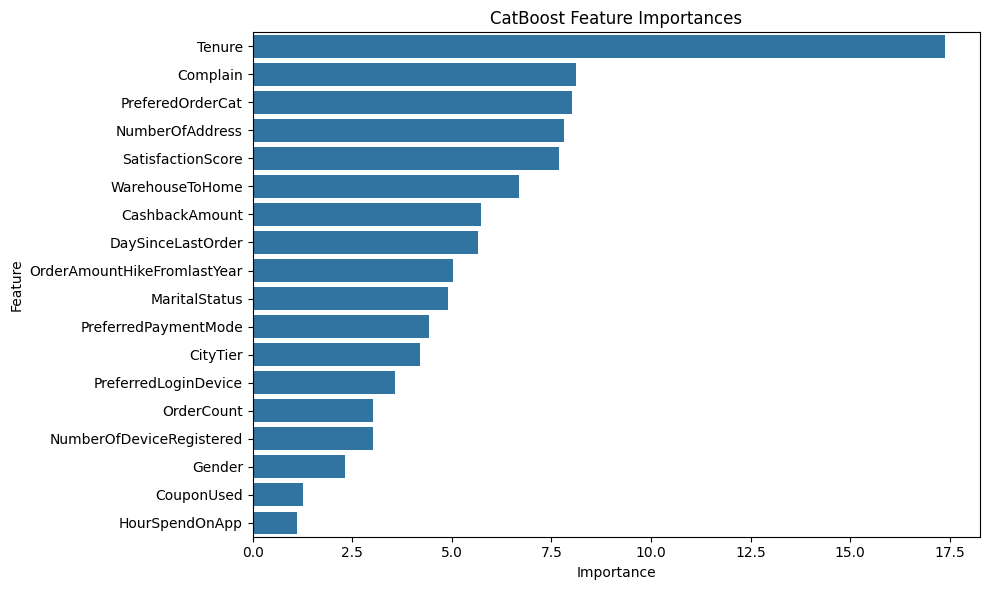

In [1]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder # For the target variable if it's string type
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Cell 2: Load the dataset
# Make sure to replace 'ECommerce_Churn_Data.csv' with the actual path/name of your dataset file if it's different.
try:
    df = pd.read_csv('ECommerce_Churn_Data.csv')
except FileNotFoundError:
    print("Error: The dataset file 'ECommerce_Churn_Data.csv' was not found.")
    print("Please download the dataset from https://www.kaggle.com/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction?resource=download")
    print("and place it in the correct directory or update the file path.")
    # Exit or raise error if file not found, to prevent further cells from running with an undefined df
    df = pd.DataFrame() # Create an empty DataFrame to avoid NameError

if not df.empty:
    print("Dataset loaded successfully:")
    print(df.head())
    print("\nDataset Info:")
    df.info()
    print("\nDataset Description:")
    print(df.describe(include='all')) # include='all' for both numerical and categorical

# Cell 3: Initial Data Exploration & Preprocessing (if dataset loaded)
if not df.empty:
    # Display column names to identify the target variable and features
    print("\nColumn Names:")
    print(df.columns)

    # Assuming 'Churn' is the target variable. Verify this based on your dataset.
    target_column = 'Churn'

    if target_column not in df.columns:
        print(f"\nError: Target column '{target_column}' not found in the dataset.")
        print("Please verify the target column name. Common names could be 'Exited', 'Target', etc.")
    else:
        print(f"\nTarget variable: '{target_column}'")
        print(f"Data type of target variable: {df[target_column].dtype}")
        print(df[target_column].value_counts(normalize=True))

        # Ensure target variable is numeric (0 or 1) for CatBoost binary classification
        # If it's not, and it's binary (e.g., 'Yes'/'No'), encode it.
        # CatBoost typically expects 0/1 for binary classification target.
        if df[target_column].dtype == 'object':
            print(f"\nTarget variable '{target_column}' is of object type. Encoding it to numeric.")
            # Example: if target is Yes/No, map Yes to 1 and No to 0
            # Adjust this mapping based on your specific target variable values
            # For the provided dataset, 'Churn' is likely already 0 or 1. If not, adjust.
            # unique_targets = df[target_column].unique()
            # if len(unique_targets) == 2:
            #     le = LabelEncoder()
            #     df[target_column] = le.fit_transform(df[target_column])
            #     print(f"Encoded target classes: {le.classes_} -> {le.transform(le.classes_)}")
            # else:
            #     print("Warning: Target variable is object type but not clearly binary. Review encoding.")
            # This dataset already has Churn as 0/1 integer. So, no explicit encoding needed here.
            pass


        # Drop CustomerID if it exists, as it's an identifier
        if 'CustomerID' in df.columns:
            df = df.drop('CustomerID', axis=1)
            print("\nDropped 'CustomerID' column.")

        # Handle missing values
        # CatBoost can handle NaNs, especially for categorical features (it can treat NaN as a separate category).
        # However, explicit imputation is often still a good practice for consistency or if using other models.
        # For simplicity, we'll fill NaNs.
        print("\nMissing values before handling:")
        print(df.isnull().sum())

        for column in df.columns:
            if df[column].isnull().any():
                if df[column].dtype == 'object':
                    df[column] = df[column].fillna(df[column].mode()[0]) # Impute with mode for object type
                elif pd.api.types.is_numeric_dtype(df[column]) and column != target_column:
                    df[column] = df[column].fillna(df[column].median()) # Impute with median for numerical
        
        print("\nMissing values after handling:")
        print(df.isnull().sum())


        # Identify categorical and numerical features
        # Ensure target_column is not in features list
        features = [col for col in df.columns if col != target_column]
        
        # CatBoost can automatically detect categorical features if they are of object or category dtype.
        # Or, we can explicitly list them. Let's identify them by dtype.
        categorical_features = df[features].select_dtypes(include=['object', 'category']).columns.tolist()
        numerical_features = df[features].select_dtypes(include=[np.number]).columns.tolist()

        # Convert object type columns to 'category' dtype for CatBoost to be certain, or ensure they are strings
        for col in categorical_features:
            df[col] = df[col].astype('category')

        print("\nCategorical Features identified for CatBoost:", categorical_features)
        print("Numerical Features:", numerical_features)
        
        # For CatBoost, it's often better to provide indices of categorical features if not inferred automatically
        # X_temp = df.drop(target_column, axis=1)
        # categorical_feature_indices = [X_temp.columns.get_loc(col) for col in categorical_features]
        # print("Categorical feature indices:", categorical_feature_indices)


# Cell 4: Prepare Data for CatBoost (if dataset processed)
if not df.empty and target_column in df.columns:
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("\nShape of X_train:", X_train.shape)
    print("Shape of X_test:", X_test.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of y_test:", y_test.shape)
    
    # Identify categorical features for CatBoost by name (it's often more robust)
    # These names should match columns in X_train and X_test
    cat_features_names = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    print(f"\nCategorical features to be passed to CatBoost: {cat_features_names}")


# Cell 5: Create and Train the CatBoost Model (if X_train, y_train exist)
if 'X_train' in locals() and 'y_train' in locals():
    # Initialize CatBoostClassifier
    # CatBoost can directly handle categorical features if specified.
    # We'll pass the names of categorical columns to `cat_features`.
    
    model_cb = CatBoostClassifier(
        iterations=500,        # Number of trees
        learning_rate=0.05,    # Learning rate
        depth=6,               # Depth of trees
        l2_leaf_reg=3,         # L2 regularization
        loss_function='Logloss',# Loss function for binary classification
        eval_metric='AUC',     # Evaluation metric for early stopping (can also be Accuracy, F1, etc.)
        random_seed=42,
        verbose=100,           # Print training progress every 100 iterations
        early_stopping_rounds=50, # Stop training if eval_metric doesn't improve for 50 rounds
        cat_features=cat_features_names # Pass names of categorical features
    )

    print("\nTraining the CatBoost model...")
    # For early stopping, we need an evaluation set
    model_cb.fit(X_train, y_train,
                 eval_set=(X_test, y_test), # Use test set for evaluation during training
                 # cat_features parameter is already set in constructor
                 )
    print("Model training complete.")

# Cell 6: Make Predictions and Evaluate the Model (if model is trained)
if 'model_cb' in locals() and 'X_test' in locals():
    # Make predictions
    y_pred_cb = model_cb.predict(X_test)
    y_pred_proba_cb = model_cb.predict_proba(X_test)[:, 1] # Probabilities for ROC AUC

    # Evaluate the model
    accuracy_cb = accuracy_score(y_test, y_pred_cb)
    roc_auc_cb = roc_auc_score(y_test, y_pred_proba_cb)
    conf_matrix_cb = confusion_matrix(y_test, y_pred_cb)
    class_report_cb = classification_report(y_test, y_pred_cb)

    print("\nCatBoost Model Evaluation:")
    print(f"Accuracy: {accuracy_cb:.4f}")
    print(f"ROC AUC Score: {roc_auc_cb:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix_cb)

    # Plotting Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_cb, annot=True, fmt='d', cmap='Greens', cbar=False,
                xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('CatBoost Confusion Matrix')
    plt.show()

    print("\nClassification Report:")
    print(class_report_cb)

# Cell 7: Feature Importance (CatBoost built-in) (if model is trained)
if 'model_cb' in locals():
    feature_importances_cb = model_cb.get_feature_importance()
    feature_names_cb = X_train.columns

    importance_df_cb = pd.DataFrame({
        'Feature': feature_names_cb,
        'Importance': feature_importances_cb
    }).sort_values(by='Importance', ascending=False)

    print("\nCatBoost Feature Importances:")
    print(importance_df_cb)

    # Plot feature importance
    plt.figure(figsize=(10, max(6, len(importance_df_cb) * 0.3))) # Adjust height dynamically
    sns.barplot(x='Importance', y='Feature', data=importance_df_cb)
    plt.title('CatBoost Feature Importances')
    plt.tight_layout()
    plt.show()